In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset

# Main Dataset Construction

In [2]:
with open('Category-Testing\A4_category_default.npy', 'rb') as f:
    A4_PSFs_raw = np.load(f)
with open('Category-Testing\A6_category_default.npy', 'rb') as f:
    A6_PSFs_raw = np.load(f)

print(len(A4_PSFs_raw))
print(len(A6_PSFs_raw))

100204
47498


In [20]:
# Reduce the size of the larger dataset (A4-640)
A4_indices = np.random.choice(range(len(A4_PSFs_raw)), len(A6_PSFs_raw))
A4_PSFs_reduced = A4_PSFs_raw[A4_indices]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A4_PSFs_reduced, A6_PSFs_raw)).astype(np.int32)
all_labels = np.concatenate((np.zeros(len(A4_PSFs_reduced)), np.ones(len(A6_PSFs_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [21]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1)
            self.labels = torch.from_numpy(all_labels[all_indices[:int(split*len(all_indices))]]).long()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1)
            self.labels = torch.from_numpy(all_labels[all_indices[int(split*len(all_indices)):]]).long()
        print(self.images.shape)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]

# make training set
PSF_training = PSFDataset(True)
# make test set
PSF_testing = PSFDataset(False)

print(type(PSF_training))
print(all_data.shape)
print(type(all_data))

torch.Size([80746, 1, 29, 29])
torch.Size([14250, 1, 29, 29])
<class '__main__.PSFDataset'>
(94996, 29, 29)
<class 'numpy.ndarray'>


In [5]:
# print(PSF_training[0][0])
print(type(PSF_training[0][1]))
print(PSF_training[0][0][0][0, 0])
print(type(PSF_training[0][0][0][0, 0]))

<class 'torch.Tensor'>
tensor(0.)
<class 'torch.Tensor'>


# Model Code

In [7]:
# model code
class CNN(nn.Module):
    # constructor
    def __init__(self, channel_widths, pooling, nonlinearity=nn.ReLU()):
        super(CNN, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            # convolution layer
            # you can play around with kernel_size, padding, and stride if you like
            # kernel_size is most likely to have an impact
            # arguments are: Conv2d(n_input_channels, n_output_channels, 
            #                       filter_side_length, padding, stride_length)
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity) # non-linearity
        # add final layer
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling # reduce each of the H x W feature maps to a single pooled value
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]
        self.linear = nn.Linear(channel_widths[-1]*self.pool_size, 2)  # score each class to obtain logits
    # forward pass
    def forward(self, x):
        B = x.size(0) # number of input images
        features = self.backbone(x) # get feature maps (B, N_feature_maps, H, W)
        pooled_features = self.global_pooling(features) # (B, N_feature_maps, 1, 1)
        pooled_features = pooled_features.view(B, -1) # (B, N_feature_maps)
        logits = self.linear(pooled_features) # (B, N_classes)
        return logits

In [29]:
def train(model, all_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            test_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return test_acc/len(dataset)

def test_classes(model, dataset):
    # Test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)

    correct_class_0 = 0
    total_class_0 = 0

    correct_class_1 = 0
    total_class_1 = 0

    model.eval()

    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)

            preds = class_logits.data.max(1)[1]

            correct_class_0 += ((preds == targets) & (targets == 0)).sum().item()
            total_class_0 += (targets == 0).sum().item()

            correct_class_1 += ((preds == targets) & (targets == 1)).sum().item()
            total_class_1 += (targets == 1).sum().item()

    print(f'Accuracy for Class 0: {correct_class_0 / total_class_0 * 100}%')
    print(f'Accuracy for Class 1: {correct_class_1 / total_class_1 * 100}%')

    overall_accuracy = (correct_class_0 + correct_class_1) / (total_class_0 + total_class_1)
    print(f'Overall Accuracy: {overall_accuracy * 100}%')


# Training

In [19]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5000 # 100 examples per class
N_validation_examples = 5000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
config = {'lr': 5e-8,
          'n_epochs': 30,
          'batch_size': 200}
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 32, 32, 16] # must start with a 1 and be at least length--2
model = CNN(channel_widths, pool_fcn)

# Train Model Fresh
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model,
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)
# Reload Previously Trained Model (Comment out training function above)
# model = torch.load('Models/model1.pt'))

Epoch 1/30: (Train) Loss = 1.2715e+02, Acc = 0.4684, (Val) Loss = 7.9869e+01, Acc = 0.4646
Epoch 2/30: (Train) Loss = 7.2758e+01, Acc = 0.4908, (Val) Loss = 6.3727e+01, Acc = 0.5074
Epoch 3/30: (Train) Loss = 5.9329e+01, Acc = 0.5330, (Val) Loss = 5.4483e+01, Acc = 0.5486
Epoch 4/30: (Train) Loss = 5.1240e+01, Acc = 0.5736, (Val) Loss = 4.8984e+01, Acc = 0.5878
Epoch 5/30: (Train) Loss = 4.6897e+01, Acc = 0.6000, (Val) Loss = 4.5894e+01, Acc = 0.6262
Epoch 6/30: (Train) Loss = 4.4427e+01, Acc = 0.6234, (Val) Loss = 4.3927e+01, Acc = 0.6394
Epoch 7/30: (Train) Loss = 4.2532e+01, Acc = 0.6376, (Val) Loss = 4.2872e+01, Acc = 0.6540
Epoch 8/30: (Train) Loss = 4.1400e+01, Acc = 0.6484, (Val) Loss = 4.1691e+01, Acc = 0.6514
Epoch 9/30: (Train) Loss = 4.0346e+01, Acc = 0.6544, (Val) Loss = 4.0852e+01, Acc = 0.6576
Epoch 10/30: (Train) Loss = 3.9363e+01, Acc = 0.6602, (Val) Loss = 4.0336e+01, Acc = 0.6684
Epoch 11/30: (Train) Loss = 3.8816e+01, Acc = 0.6668, (Val) Loss = 3.9687e+01, Acc = 0.66

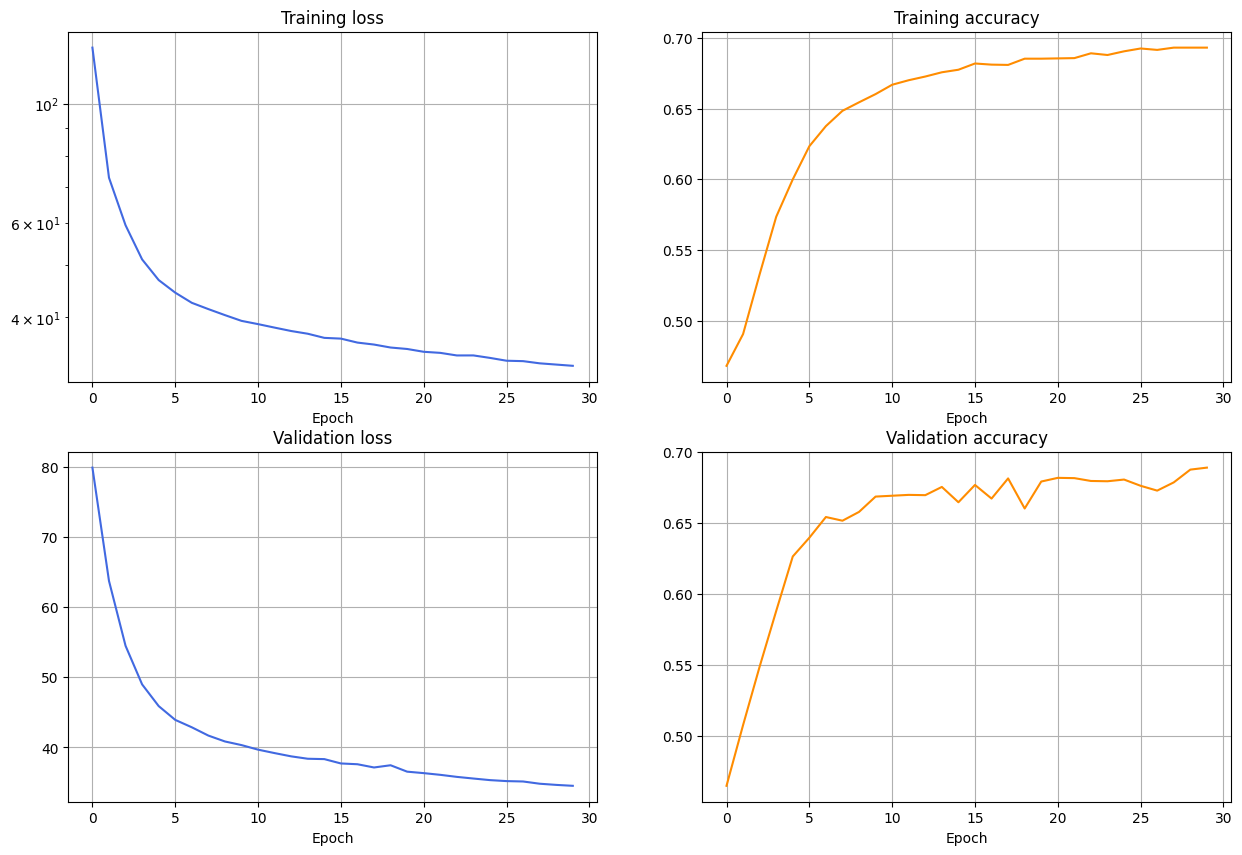

In [24]:
# plot training/validation loss and accuracy over training time
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.semilogy(train_losses, color='royalblue')
plt.xlabel('Epoch')
plt.title('Training loss')
plt.grid(True)
plt.subplot(222)
plt.plot(train_accs, color='darkorange')
plt.xlabel('Epoch')
plt.title('Training accuracy')
plt.grid(True)
plt.subplot(223)
plt.plot(val_losses, color='royalblue')
plt.xlabel('Epoch')
plt.title('Validation loss')
plt.grid(True)
plt.subplot(224)
plt.plot(val_accs, color='darkorange')
plt.xlabel('Epoch')
plt.title('Validation accuracy')
plt.grid(True)

In [35]:
torch.save(model, 'Models/model1.pt')

# Category Testing

In [17]:
with open('Category-Testing\A4_category_tight.npy', 'rb') as f:
    A4_PSFs_tight = np.load(f)
with open('Category-Testing\A6_category_tight.npy', 'rb') as f:
    A6_PSFs_tight = np.load(f)
with open('Category-Testing\A4_category_worst.npy', 'rb') as f:
    A4_PSFs_worst = np.load(f)
with open('Category-Testing\A6_category_worst.npy', 'rb') as f:
    A6_PSFs_worst = np.load(f)
with open('Category-Testing\A4_category_bright.npy', 'rb') as f:
    A4_PSFs_bright = np.load(f)
with open('Category-Testing\A6_category_bright.npy', 'rb') as f:
    A6_PSFs_bright = np.load(f)
with open('Category-Testing\A4_category_dark.npy', 'rb') as f:
    A4_PSFs_dark = np.load(f)
with open('Category-Testing\A6_category_dark.npy', 'rb') as f:
    A6_PSFs_dark = np.load(f)

print(len(A4_PSFs_tight), len(A6_PSFs_tight))
print(len(A4_PSFs_worst), len(A6_PSFs_worst))
print(len(A4_PSFs_bright), len(A6_PSFs_bright))
print(len(A4_PSFs_dark), len(A6_PSFs_dark))

49792 20368
10174 4444
12322 11168
13673 2159


In [22]:
raw_categories = {'tight': [A4_PSFs_tight, A6_PSFs_tight], 'worst': [A4_PSFs_worst, A6_PSFs_worst], 'bright': [A4_PSFs_bright, A6_PSFs_bright], 'dark': [A4_PSFs_dark, A6_PSFs_dark]}
cat_data = {}
cat_indices = {}
cat_labels = {}
for category in raw_categories:
    A4_PSFs_cat = raw_categories[category][0]
    A6_PSFs_cat = raw_categories[category][1]

    # Reduce the size of the larger dataset (A4-640)
    A4_cat_indices = np.random.choice(range(len(A4_PSFs_cat)), len(A6_PSFs_cat))
    A4_PSFs_cat_reduced = A4_PSFs_cat[A4_cat_indices]

    # Combine, create labels, and reshuffle all
    all_cat_data = np.concatenate((A4_PSFs_cat_reduced, A6_PSFs_cat)).astype(np.int32)
    these_cat_labels = np.concatenate((np.zeros(len(A4_PSFs_cat_reduced)), np.ones(len(A6_PSFs_cat))))

    random_seed = 1 # random seed for reproducibility
    np.random.seed(random_seed)
    all_cat_indices = np.random.choice(np.arange(len(all_cat_data)), size=len(all_cat_data), replace=False)
    
    cat_data[category] = all_cat_data
    cat_labels[category] = these_cat_labels
    cat_indices[category] = all_cat_indices

In [25]:
class Categories_Dateset(Dataset):
    def __init__(self, category):
        data = cat_data[category]
        labels = cat_labels[category]
        indices = cat_indices[category]
        self.images = torch.from_numpy(data[indices]).unsqueeze(1)
        self.labels = torch.from_numpy(labels[indices]).long()
        print(self.images.shape)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]
    
# make category testing sets
Category_Testing = {}
for category in cat_data:
    Category_Testing[category] = Categories_Dateset(category=category)

torch.Size([40736, 1, 29, 29])
torch.Size([8888, 1, 29, 29])
torch.Size([22336, 1, 29, 29])
torch.Size([4318, 1, 29, 29])


In [33]:
print("Tight Sorting Accuracy:")
test_classes(model, Category_Testing['tight'])
print("\nWorst Sorting Accuracy:")
test_classes(model, Category_Testing['worst'])
print("\nBright Sorting Accuracy:")
test_classes(model, Category_Testing['bright'])
print("\nDark Sorting Accuracy:")
test_classes(model, Category_Testing['dark'])
print("\nOverall Sorting Accuracy:")
test_classes(model, PSF_testing)

Tight Sorting Accuracy:
Accuracy for Class 0: 76.94913589945011%
Accuracy for Class 1: 67.28692065985861%
Overall Accuracy: 72.11802827965435%

Worst Sorting Accuracy:
Accuracy for Class 0: 67.91179117911791%
Accuracy for Class 1: 58.66336633663366%
Overall Accuracy: 63.287578757875785%

Bright Sorting Accuracy:
Accuracy for Class 0: 76.7102435530086%
Accuracy for Class 1: 26.06554441260745%
Overall Accuracy: 51.387893982808016%

Dark Sorting Accuracy:
Accuracy for Class 0: 62.43631310792034%
Accuracy for Class 1: 97.40620657711904%
Overall Accuracy: 79.92125984251969%

Overall Sorting Accuracy:
Accuracy for Class 0: 74.28092711533091%
Accuracy for Class 1: 66.73250564334086%
Overall Accuracy: 70.52631578947368%
